# [Issue 12](https://github.com/alkaline-ml/pyramid/issues/12)

The purpose of this notebook is to debug issue 12

Here is the Pyramid version info:

In [1]:
import pmdarima as pm
print("Pyramid version: %r" % pm.__version__)

Pyramid version: '1.0.0-dev'


### Read the data in:

In [2]:
import pandas as pd

data = pd.read_csv('dummy_data.csv')
data.head()

,time,occupancy
0,2017-03-01 00:02:01,2
1,2017-03-01 00:04:01,3
2,2017-03-01 00:06:01,2
3,2017-03-01 00:08:01,1
4,2017-03-01 00:10:01,4


### Determining the periodicity

Our issue filer claims that the periodicity of the data is every 2 minutes:

> I have a seasonal time-series data set which comprises of 2 months of data. Now if I mention the frequency as "2 min" or "365x24x30" then it tries to divide the dataset with that frequency. But my data set is just for 2 months and obviously, it has way lesser values than the freq.

Therefore, rather than use `365 * 24 * 30 = 262800`, we can probably use the number of days in the two months (say, 60) instead of the 365: `60 * 24 * 30 = 43200`

In [3]:
n_days = 60
n_hours = 24
n_minutes = 30  # every other minute

# determine m:
m = n_days * n_hours * n_minutes
m

43200

However, `m` is greater than the number of samples in the data, which is suspect... *unless there is LOTS of data, it's unlikely we have a bi-minutely seasonal period...*

In [4]:
print("n_periods: %i" % m)
print("n_samples: %i" % data.shape[0])

n_periods: 43200
n_samples: 1610


On inspection of the data, it's clear that there is a 2 minute interval between each sample, __but what is the *actual* seasonality__? That's what we're unsure of. Let's take a look:

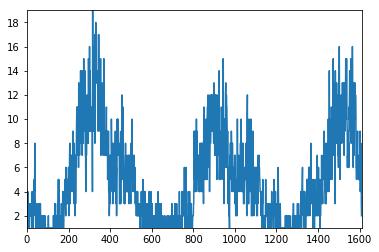

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# extract the data we're interested in
n_samples = data.shape[0]
xlab, y = data.time, data.occupancy

plt.plot(np.arange(n_samples), y)
plt.axis([0, n_samples, y.min(), y.max()])
plt.show()

__We can see that even though the data is separated at a 2-minute interval, the seasonality is VERY DIFFERENT (and much less frequent)__. Therefore, part of the issue is the assumption that the actual data frequency is equivalent to the seasonality. *It is not!!* It looks like we have 3 seasons in a 2 month period, which means we likely have 18 seasons over the course of the year (3 * 6). Only 3 are in the sample, however, and the algo is time invariant (i.e., it has no idea whether this is a year or a month; it only knows there are `m` seasons). Therefore, we'll set `m` to 3.

This is really important to understand: the `m` parameter must be apriori knowledge!! Even R's `auto.arima` will have a tough time fitting a model for a `ts` with unknown frequency.

## Stationarity

Stationarity is an important part of ARIMA analysis. There are several avenues we can explore in order to attempt to make a time series stationary, but one of the more common ones is differencing. `pyramid` provides a differencing method that can be used for this (`diff`), and also provides a function that can estimate the number of diffs required to reach stationarity (`ndiffs`). Before we can difference the actual timeseries, however, we need to address the pretty apparent seasons in the data. We can estimate the order of seasonal differencing using `nsdiffs`.

In [7]:
from pmdarima.arima.utils import nsdiffs

# Test for best nsdiffs (assuming m is 3, as previously shown)
nsdiffs(y, m=3, max_D=5, test='ch')

0

`nsdiffs` shows that we do not need to perform any seasonal differencing, so we can turn our attention to differencing with `ndiffs`.

In [8]:
from pmdarima.arima.utils import ndiffs, diff

# Test for best ndiffs at the p < 0.05 level
ndiffs(y, alpha=0.05, test='kpss', max_d=5)

1

`ndiffs` asserts that we should only difference once. Let's look at how the time series looks after differencing once:

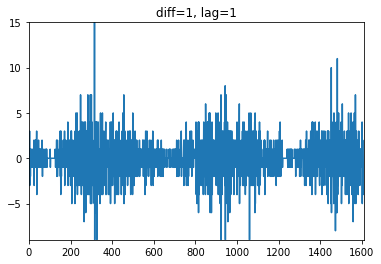

In [9]:
def plot_ts(x, title="Time series"):
    n_samples = x.shape[0]

    plt.plot(np.arange(n_samples), x)
    plt.axis([0, n_samples, x.min(), x.max()])
    plt.title(title)
    plt.show()
    
plot_ts(diff(y, differences=1, lag=1), title="diff=1, lag=1")

Note that `auto_arima` will only ever use `lag=1` while differencing, and that these estimations all happen under the covers in `auto_arima`. There is not a need to difference prior to using `auto_arima`, as it will find the optimal differencing orders for you.

Let's try fitting an ARIMA using `auto_arima`.

In [10]:
from pmdarima.arima import auto_arima

# We'll give it a broad range of parameters to search, though it might take a bit.
arima = auto_arima(y,  # this is our unlagged data
                   exogenous=None,  # if you have covariates, you can regress against them as well (optionally)
                   start_p=1, max_p=5,
                   start_q=1, max_q=5,
                   start_P=1, max_P=3,
                   start_Q=1, max_Q=3,
                   d=1, D=0,  # we have already estimated our d and D, so no need to compute it again
                   max_order=None,  # do not limit the order of parameters for this search
                   stepwise=True,  # faster
                   error_action='ignore',  # do not care if we find parameters that fail; skip them
                   trace=True, seasonal=True, m=3)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 3); AIC=6452.402, BIC=6484.702, Fit time=0.880 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 3); AIC=7083.345, BIC=7094.112, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 3); AIC=6761.848, BIC=6783.381, Fit time=0.119 seconds


/anaconda3/envs/pmdenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/anaconda3/envs/pmdenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 3); AIC=6468.459, BIC=6489.993, Fit time=0.228 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 3); AIC=6450.426, BIC=6477.343, Fit time=0.292 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 3); AIC=6452.211, BIC=6473.744, Fit time=0.166 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 2, 3); AIC=6452.425, BIC=6484.725, Fit time=0.507 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 3); AIC=6454.425, BIC=6492.109, Fit time=0.592 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 1, 3); AIC=6451.633, BIC=6483.933, Fit time=0.386 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 1, 3); AIC=6761.850, BIC=6783.384, Fit time=0.110 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 1, 3); AIC=6456.689, BIC=6488.989, Fit time=0.552 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 3); AIC=7081.687, BIC=7097.837, Fit time=0.091 seconds


/anaconda3/envs/pmdenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 3); AIC=6454.177, BIC=6491.861, Fit time=0.912 seconds
Total fit time: 4.864 seconds


In [11]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1610
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 3)   Log Likelihood               -3220.213
Date:                           Fri, 02 Nov 2018   AIC                           6450.426
Time:                                   15:37:48   BIC                           6477.343
Sample:                                        0   HQIC                          6460.419
                                          - 1610                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.007      0.212      0.832      -0.013       0.016
ar.L1          0.1599      0.025      6.348      0.000       0.111       0.209
ma.L1         -0.8480      0.016    -51.924      0.000      -0.880      -0.816
ma.S.L3        0.0557      0.023      2.400      0.016       0.010       0.101
sigma2         3.2036      0.085     37.733      0.000       3.037       3.370
===================================================================================
Ljung-Box (Q):                       58.59   Jarque-Bera (JB):               276.16
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.38
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Running R's `auto.arima` found the exact same parameters with almost the same exact AIC, BIC, etc.

```R
> library(forecast)
> df = read.csv('dummy_data.csv')
> head(df)
                 time occupancy
1 2017-03-01 00:02:01         2
2 2017-03-01 00:04:01         3
3 2017-03-01 00:06:01         2
4 2017-03-01 00:08:01         1
5 2017-03-01 00:10:01         4
6 2017-03-01 00:12:01         1
> y = ts(df$occupancy, frequency=3)
>
> auto.arima(y)
Series: y
ARIMA(1,1,1)(0,0,1)[3]

Coefficients:
         ar1      ma1    sma1
      0.1598  -0.8479  0.0557
s.e.  0.0330   0.0198  0.0283

sigma^2 estimated as 3.21:  log likelihood=-3220.24
AIC=6448.47   AICc=6448.5   BIC=6470.01
```

To predict your next value, you simply call `predict`. Note that once you've discovered your parameters, you'll periodically have to refresh your model with new data as it comes in. Since `ARIMA`s use the most recent values to project into the future, you will not want to predict many values into the future; only several at a time. Here's how we can forecast the next three values:

In [12]:
print("Last few values: %r" % y[-5:].tolist())
print("Nex three predicted values: %r" % arima.predict(n_periods=3))

Last few values: [7, 8, 7, 3, 2]
Nex three predicted values: array([4.72557485, 4.94374601, 4.95691855])
